In [1]:
import mdshare
import numpy as np
import torch
from torch import nn
local_filename = mdshare.fetch('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')
with np.load(local_filename) as fh:
    trajs = [fh[key] for key in sorted(fh.keys())]

ModuleNotFoundError: No module named 'mdshare'

In [2]:
traj = trajs[0]

In [3]:
train_data = np.stack([np.cos(traj[:, 0]), np.sin(traj[:, 0]), np.cos(traj[:, 1]), np.sin(traj[:, 1])], 1)

In [4]:
loader = torch.utils.data.DataLoader(torch.from_numpy(train_data).float(), batch_size=256, shuffle=True, drop_last=True)

In [5]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, hidden: int = 64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim+1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, dim)
        )
    
    def forward(self, x_t, t):
        return self.model(torch.cat([x_t, t], dim=1))

In [6]:
flow = Flow(4, 256)
optimizer = torch.optim.Adam(flow.parameters(), 1e-3)
loss_fn = nn.MSELoss()

In [7]:
batch_size = 256
epochs = 10
for epoch in range(epochs):
    for i, data in enumerate(loader):
        z = torch.randn_like(data) 
        
        epsilon = torch.randn_like(data)

        t = torch.rand(size=(batch_size, 1))

        x_t = (1-t)*z + t*data + 0.1*torch.sqrt(t*(1-t))*epsilon
        
        u_t = (data-x_t)/(1-t)

        optimizer.zero_grad()
        loss = loss_fn(flow(x_t, t), u_t)
        loss.backward()
        optimizer.step()
        
        if (epoch % 10 == 0) and (i == 0):
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 1.597040


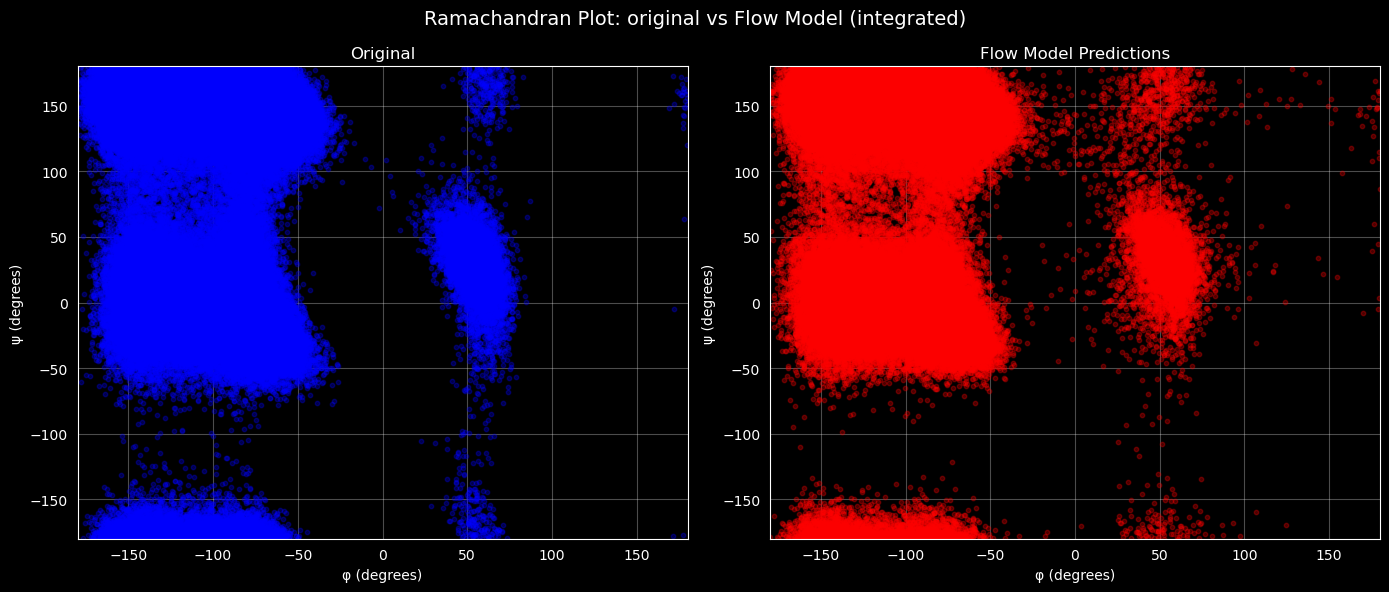

In [8]:
import matplotlib.pyplot as plt

# Define integration function
def integrate(x0, v, t=1.0, steps=100):
    dt = t/steps
    xs = [x0]
    x = x0
    for k in range(steps):
        t_k = torch.full((x.shape[0], 1), k * dt)
        x = x + dt * v(x, t_k)
        xs.append(x)
    return torch.stack(xs)

# Generate samples from the flow model
flow.eval()
with torch.no_grad():
    z_samples = torch.randn(200000, 4)
    # Integrate from t=0 to t=1
    trajectory = integrate(z_samples, flow, t=1.0, steps=100)
    flow_samples = trajectory[-1]  # Get final state at t=1

# Extract the traj[2] values
traj_2 = trajs[2]
data_traj2 = np.stack([np.cos(traj_2[:, 0]), np.sin(traj_2[:, 0]), np.cos(traj_2[:, 1]), np.sin(traj_2[:, 1])], 1)

# Convert from (cos, sin) representation back to angles
phi_traj2 = np.arctan2(data_traj2[:, 1], data_traj2[:, 0]) * 180 / np.pi
psi_traj2 = np.arctan2(data_traj2[:, 3], data_traj2[:, 2]) * 180 / np.pi

flow_np = flow_samples.numpy()
phi_flow = np.arctan2(flow_np[:, 1], flow_np[:, 0]) * 180 / np.pi
psi_flow = np.arctan2(flow_np[:, 3], flow_np[:, 2]) * 180 / np.pi

# Create Ramachandran plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Ramachandran Plot: original vs Flow Model (integrated)', fontsize=14)

# Plot traj[2] data
ax1.scatter(phi_traj2, psi_traj2, alpha=0.3, s=10, c='blue')
ax1.set_xlabel('φ (degrees)')
ax1.set_ylabel('ψ (degrees)')
ax1.set_title('Original')
ax1.set_xlim(-180, 180)
ax1.set_ylim(-180, 180)
ax1.grid(True, alpha=0.3)

# Plot flow model predictions
ax2.scatter(phi_flow, psi_flow, alpha=0.3, s=10, c='red')
ax2.set_xlabel('φ (degrees)')
ax2.set_ylabel('ψ (degrees)')
ax2.set_title('Flow Model Predictions')
ax2.set_xlim(-180, 180)
ax2.set_ylim(-180, 180)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
from matplotlib.colors import LogNorm

# Create 2D density histograms for original data
H_orig, phi_edges, psi_edges = np.histogram2d(
    phi_traj2,
    psi_traj2,
    bins=50,
    range=[[-180, 180], [-180, 180]],
    density=True
)

# Create 2D density histograms for flow model samples
H_flow, _, _ = np.histogram2d(
    phi_flow,
    psi_flow,
    bins=50,
    range=[[-180, 180], [-180, 180]],
    density=True
)

# Plot comparison with log scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('2D Ramachandran Density Comparison (Log Scale)', fontsize=14, y=1.00)

# Original data
im1 = ax1.imshow(H_orig.T, origin='lower', extent=[-180, 180, -180, 180], 
                 cmap='hot', norm=LogNorm(vmin=H_orig[H_orig > 0].min(), vmax=H_orig.max()))
ax1.set_xlabel('φ (degrees)')
ax1.set_ylabel('ψ (degrees)')
ax1.set_title('Original Data (traj[2])')
plt.colorbar(im1, ax=ax1, label='Density (log scale)')

# Flow model samples
im2 = ax2.imshow(H_flow.T, origin='lower', extent=[-180, 180, -180, 180], 
                 cmap='hot', norm=LogNorm(vmin=H_flow[H_flow > 0].min(), vmax=H_flow.max()))
ax2.set_xlabel('φ (degrees)')
ax2.set_ylabel('ψ (degrees)')
ax2.set_title('Flow Model Samples')
plt.colorbar(im2, ax=ax2, label='Density (log scale)')

plt.tight_layout()
plt.show()

print(f"Original data statistics:")
print(f"  Samples: {len(phi_traj2)}")
print(f"  Density range: [{H_orig.min():.2e}, {H_orig.max():.2e}]")
print(f"\nFlow model statistics:")
print(f"  Samples: {len(phi_flow)}")
print(f"  Density range: [{H_flow.min():.2e}, {H_flow.max():.2e}]")

Original data statistics:
  Samples: 250000
  Density range: [0.00e+00, 2.52e-04]

Flow model statistics:
  Samples: 200000
  Density range: [0.00e+00, 2.79e-04]


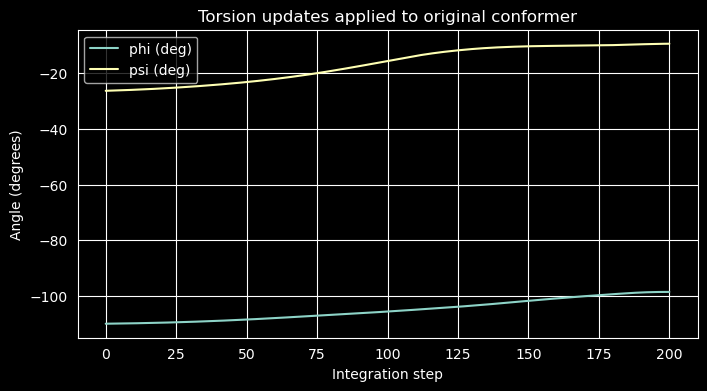

In [10]:
# Stepwise application of the learned velocity field to a real conformer
# The idea: start from a real conformer (phi0, psi0), represent as (cos,sin)
# then apply small flow steps x <- x + dt * v(x,t) and record the torsion change
# at each step, update the conformer's dihedral angles by the incremental change.

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

# small utility to unwrap angle differences to [-pi, pi]
def unwrap_delta(delta):
    delta = (delta + np.pi) % (2 * np.pi) - np.pi
    return delta


def apply_flow_to_conformer(phi0, psi0, flow, steps=100, dt=None, return_path=True):
    """
    Apply the learned velocity field incrementally to an existing conformer.
    - phi0, psi0: initial angles in radians (scalars)
    - flow: the trained model, expects inputs (x_t, t) where x_t is [cosφ,sinφ,cosψ,sinψ]
    - steps: number of Euler steps
    - dt: step size (if None, dt=1/steps)
    Returns: dict with 'phis', 'psis', 'coords_path' (if build_backbone available)
    """
    flow.eval()
    if dt is None:
        dt = 1.0 / steps

    # current conformer angles (the "original model" we will update)
    phi_cur = float(phi0)
    psi_cur = float(psi0)

    # start representation x = [cosφ,sinφ,cosψ,sinψ]
    x = np.array([math.cos(phi_cur), math.sin(phi_cur), math.cos(psi_cur), math.sin(psi_cur)], dtype=np.float32)

    phis = [phi_cur]
    psis = [psi_cur]
    coords_path = []

    # if build_backbone is defined in the notebook, store coordinates
    have_builder = 'build_backbone' in globals()
    if have_builder:
        coords_path.append(build_backbone(phi_cur, psi_cur))

    prev_angles = np.array([phi_cur, psi_cur])

    with torch.no_grad():
        for k in range(steps):
            t_k = torch.full((1, 1), k * dt, dtype=torch.float32)
            x_tensor = torch.from_numpy(x).unsqueeze(0)  # shape (1,4)

            v = flow(x_tensor, t_k).squeeze(0).numpy()  # shape (4,)

            # Euler step in representation space
            x = x + dt * v

            # Recompute angles from (cos, sin)
            phi_new = math.atan2(float(x[1]), float(x[0]))
            psi_new = math.atan2(float(x[3]), float(x[2]))

            angles_new = np.array([phi_new, psi_new])
            delta = unwrap_delta(angles_new - prev_angles)

            # Apply torsion update to the *original* conformer (incremental)
            phi_cur = float(phi_cur + delta[0])
            psi_cur = float(psi_cur + delta[1])

            prev_angles = angles_new

            phis.append(phi_cur)
            psis.append(psi_cur)

            if have_builder:
                coords_path.append(build_backbone(phi_cur, psi_cur))

    out = {'phis': np.array(phis), 'psis': np.array(psis)}
    if have_builder:
        out['coords_path'] = np.stack(coords_path)
    return out


# Example usage on a conformer from trajs[2]
# pick an index (ensure traj_2 exists from earlier cells)
if 'traj_2' not in globals() and 'trajs' in globals():
    traj_2 = trajs[2]

sample_index = 10 if (('traj_2' in globals() and len(traj_2) > 10) ) else 0
phi0 = float(traj_2[sample_index, 0])
psi0 = float(traj_2[sample_index, 1])

print(f"Applying flow steps to conformer index {sample_index}: phi={np.degrees(phi0):.1f}°, psi={np.degrees(psi0):.1f}°")

result = apply_flow_to_conformer(phi0, psi0, flow, steps=200)

# Plot the torsion evolution (degrees)
plt.figure(figsize=(8,4))
plt.plot(np.degrees(result['phis']), label='phi (deg)')
plt.plot(np.degrees(result['psis']), label='psi (deg)')
plt.xlabel('Integration step')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.title('Torsion updates applied to original conformer')
plt.grid(True)
plt.show()

# If coords_path available, show first, middle, final backbone in 3D
if 'coords_path' in result:
    coords = result['coords_path']
    n = coords.shape[0]
    mid = n // 2

    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(131, projection='3d')
    ax.plot(coords[0,:,0], coords[0,:,1], coords[0,:,2], 'o-', label='start')
    ax.set_title('Start')
    ax = fig.add_subplot(132, projection='3d')
    ax.plot(coords[mid,:,0], coords[mid,:,1], coords[mid,:,2], 'o-', label='mid')
    ax.set_title('Mid')
    ax = fig.add_subplot(133, projection='3d')
    ax.plot(coords[-1,:,0], coords[-1,:,1], coords[-1,:,2], 'o-', label='end')
    ax.set_title('End')
    plt.tight_layout()
    plt.show()

    # Optionally save final as PDB
    if 'build_alanine_dipeptide_pdb' in globals():
        out_pdb = build_alanine_dipeptide_pdb(result['phis'][-1], result['psis'][-1], 'flow_updated_conformer.pdb')
        print('Saved final updated conformer to', out_pdb)